In [1]:
import sys
sys.path.append("../utils")
from utils import load_data, create_mlp_sae
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import Keras for implementing autoencoders
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from pathlib import Path
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

2024-11-24 12:33:08.553231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train, test, train_target = load_data(raw = False, categorical=False)

In [3]:
# Add the project root directory to the Python path
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'preprocessed'
train_augmented = pd.read_csv(data_path / 'train_augmented.csv')

In [4]:
# Check mean and std of the data
train_augmented.describe().T[['mean', 'std']]

,mean,std
A1BG,6.798991e-16,0.966860
A1CF,3.423397e-16,0.693327
A2M,-4.606349e-16,0.999384
A2ML1,3.294604e-16,0.832207
A3GALT2,-3.096477e-15,0.784132
...,...,...
ZXDC,-2.804695e-15,0.999384
ZYG11A,-1.676581e-15,0.915827
ZYG11B,1.130028e-15,0.835653
ZYX,-2.479274e-15,0.999384


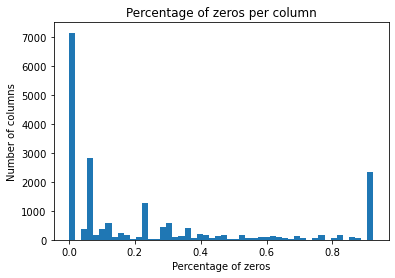

AADACL3         0.825413
AARS1           0.923843
ABHD14A-ACY1    0.923843
ABHD18          0.923843
ABITRAM         0.923843
                  ...   
ZNF875          0.923843
ZNRD2           0.923843
ZSCAN5C         0.915016
ZSWIM9          0.923843
ZUP1            0.923843
Length: 2746, dtype: float64


In [5]:
# Plot percentage of samples == 0  per columns
percentage_zeros = (train_augmented == 0).mean()
percentage_zeros.plot(kind='hist', bins=50)
plt.xlabel('Percentage of zeros')
plt.ylabel('Number of columns')
plt.title('Percentage of zeros per column')
plt.show()
# Print all columns with more than 90% zeros
print(percentage_zeros[percentage_zeros > 0.8])

In [6]:
# Get all columns with more than 80% zeros
columns_to_drop = percentage_zeros[percentage_zeros > 0.8].index
# drop these columns
train_augmented = train_augmented.drop(columns=columns_to_drop)
train = train.drop(columns=columns_to_drop)
train_augmented.shape

(9743, 17161)

In [7]:
train.shape

(742, 17161)

In [8]:
# Split the data
new_X_train, new_X_test = train_test_split(train_augmented, test_size=0.2, random_state=42)
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(train, train_target, test_size=0.2, random_state=42)

In [ ]:
# Define the autoencoder architecture
input_dim = new_X_train.shape[1]
encoding_dim = 5

# Set the encoding dimension
input_layer = keras.layers.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation="relu")(input_layer)
decoder = keras.layers.Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the autoencoder architecture
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 17161)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        85,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17161)          │       102,966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,776 (737.41 KB)

 Trainable params: 188,776 (737.41 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
autoencoder.fit(new_X_train, new_X_train, epochs=10, batch_size=32, shuffle=True, validation_data=(new_X_test, new_X_test))

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.7699 - val_loss: 0.7799
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7719 - val_loss: 0.7793
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7686 - val_loss: 0.7786
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7666 - val_loss: 0.7787
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7735 - val_loss: 0.7788
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7751 - val_loss: 0.7787
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7751 - val_loss: 0.7784
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7712 - val_loss: 0.7782
Epoch 9/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7745 - val_loss: 0.7778
Epoch 10/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7653 - val_loss: 0.7774


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Encoded Features Shape (Train): (593, 5)
Encoded Features Shape (Test): (149, 5)


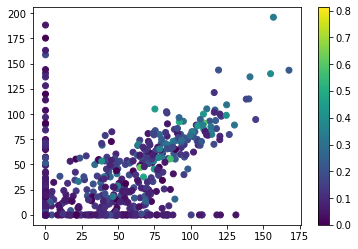

In [43]:
# Use encoder part of the autoencoder for feature selection
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
encoded_features_train = encoder.predict(X_train)
encoded_features_test = encoder.predict(X_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)
# plot all encoded features
plt.scatter(encoded_features_train[:,0], encoded_features_train[:,1], c = y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.show()

In [44]:
# --- Encoded Features ---
# Fit a linear regression model using the encoded features
encoded_model = LinearRegression()
encoded_model.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred_encoded = encoded_model.predict(encoded_features_test)

# Calculate regression metrics
mse_encoded = mean_squared_error(y_test, y_pred_encoded)
r2_encoded = r2_score(y_test, y_pred_encoded)

# Calculate Spearman's rank correlation for encoded features
spearman_encoded, p_value_encoded = spearmanr(y_test, y_pred_encoded)

print("--- Encoded Features ---")
print("Mean Squared Error (MSE):", mse_encoded)
print("R-squared (R²):", r2_encoded)
print("Spearman's Correlation (ρ):", spearman_encoded)
print("P-value (Spearman):", p_value_encoded)

# --- Non Encoded Features ---
# Fit a linear regression model using the non-encoded features
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate Spearman's rank correlation for non-encoded features
spearman_non_encoded, p_value_non_encoded = spearmanr(y_test, y_pred)

print("--- Non Encoded Features ---")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Spearman's Correlation (ρ):", spearman_non_encoded)
print("P-value (Spearman):", p_value_non_encoded)


--- Encoded Features ---
Mean Squared Error (MSE): 0.006141569559594833
R-squared (R²): 0.1796013723015717
Spearman's Correlation (ρ): 0.39909522863722985
P-value (Spearman): 4.6155924325362254e-07
--- Non Encoded Features ---
Mean Squared Error (MSE): 0.006584174183452588
R-squared (R²): 0.12047768697937256
Spearman's Correlation (ρ): 0.40608417021980264
P-value (Spearman): 2.772350380170964e-07


# VAE

In [45]:
from src.utils.vae import VAE, train
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [47]:
# Use VAE for feature selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalize the data
scaler = MinMaxScaler()
new_X_train_scaled = scaler.fit_transform(new_X_train)

# Convert to tensor
new_X_train_tensor = torch.tensor(new_X_train_scaled, dtype=torch.float32)
dataset = TensorDataset(new_X_train_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

input_dim = new_X_train.shape[1]
latent_dim = 2
model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_loader, optimizer, epochs=10, device=device)

Epoch 1/10, Average Loss: 982496.8392
Epoch 2/10, Average Loss: 12428.3154
Epoch 3/10, Average Loss: 11149.2655
Epoch 4/10, Average Loss: 10774.9636
Epoch 5/10, Average Loss: 10613.9831
Epoch 6/10, Average Loss: 10528.8288
Epoch 7/10, Average Loss: 10478.4021
Epoch 8/10, Average Loss: 10446.1445
Epoch 9/10, Average Loss: 10424.2226
Epoch 10/10, Average Loss: 10408.8444


81126533.546875

Encoded Features Shape (Train): torch.Size([593, 2])


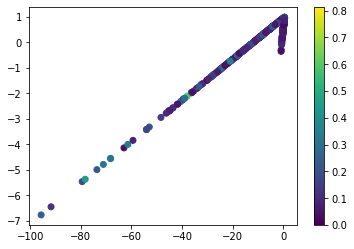

In [48]:
# Extract the latent features
encoded_features_train, _ = model.encode(torch.tensor(X_train.values, dtype=torch.float32).to(device))
print("Encoded Features Shape (Train):", encoded_features_train.shape)
# plot all encoded features
plt.scatter(encoded_features_train[:,0].cpu().detach().numpy(), encoded_features_train[:,1].cpu().detach().numpy(), c = y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.show()

In [49]:
# Use the encoded features for regression
encoded_features_test, _ = model.encode(torch.tensor(X_test.values, dtype=torch.float32).to(device))
model = LinearRegression()
model.fit(encoded_features_train.cpu().detach().numpy(), y_train)
# Make predictions on the test set
y_pred_encoded = model.predict(encoded_features_test.cpu().detach().numpy())
# Calculate regression metrics
mse_encoded = mean_squared_error(y_test, y_pred_encoded)
r2_encoded = r2_score(y_test, y_pred_encoded)
# Calculate Spearman's rank correlation for encoded features
spearman_encoded, p_value_encoded = spearmanr(y_test, y_pred_encoded)
print("--- Encoded Features ---")
print("Mean Squared Error (MSE):", mse_encoded)
print("R-squared (R²):", r2_encoded)
print("Spearman's Correlation (ρ):", spearman_encoded)
print("P-value (Spearman):", p_value_encoded)

--- Encoded Features ---
Mean Squared Error (MSE): 0.00752379039312154
R-squared (R²): -0.005037434439599364
Spearman's Correlation (ρ): 0.09756946995239815
P-value (Spearman): 0.2364987172531474
